# 00 - IMPORTS

In [10]:
import pandas.io.sql as psql
import psycopg2 as pg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import random

from dython.nominal import associations
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lr
from sklearn import metrics as mt
from sklearn import model_selection as ms
from sklearn import datasets, linear_model
from matplotlib import pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

## 0.1 - Functions

In [3]:
 def precision_at_k( data, k=2000, model_name=str):
    '''
    --> Calculate the model precision at the k position in ranking
    
    :param dataframe data: The data with response and probabilities calculated
    :param int k: The k ranking position to return the precision
    :param str model_name: The name of Machine Learning model that calculate the probabilites
    
    print The precison at k ranking position
    ''' 

In [4]:
def precision_recall_at_k( yval, yhat_proba, k=38000, model_name='' ):
    
    df = pd.DataFrame()
    #df = x_val.copy()
    df['y_actual'] = yval
    df['proba'] = yhat_proba[:,1].tolist()
    
    df = df.sort_values('proba', ascending=False)
    # extract the k rows    
    dfK = df[ ['y_actual', 'proba'] ].head(k)

    # compute number of recommended items @k
    denominator_precision = k
    denominator_recall = df['y_actual'].sum()
    #compute number of recommended items that are relevant @k
    numerator = dfK[ dfK['y_actual']==1 ].shape[0]
    #print( numerator, denominator_recall, numerator/denominator_recall )

    precision_at_k = numerator/denominator_precision
    recall_at_k = numerator/denominator_recall
    
    print(f"Model: {model_name} \nRanking Position: {k} \nPrecision: {round(precision_at_k, 5)} \nRecall: {round(recall_at_k, 5)}")
    
    return { 'precision_at_k': round(precision_at_k,5), 'recall_at_k': round(recall_at_k, 5) }
    
    

In [5]:
def kfold_cv(df, model, model_name='' , kfolds=5, topk=2000 ):
    
    X = df.iloc[ : , 0:-1 ]
    y = pd.DataFrame( df['response' ] )
    
    skf = ms.StratifiedKFold( n_splits=kfolds )
    cv = skf.split( X, y )

    
    precision_list = []
    recall_list = []
    
    for i, (train_index, val_index) in enumerate(cv):
        print(f"\nFold {i}:")
    
        Xtrain = X.loc[ train_index, : ]
        ytrain = y.loc[ train_index, : ]
        
        Xval = X.loc[ val_index, : ]
        yval = y.loc[ val_index, : ]
    
        #model training
        ytrain = ytrain.astype('int')
        model.fit( Xtrain,ytrain )

        #model prediction over data it never saw - generalization
        yhat_proba = model.predict_proba( Xval )
    
        result = precision_recall_at_k( yval, yhat_proba, k=topk, model_name=model_name )
        display(result)
        
        #store performance in each kfold iteration
        precision_list.append( result['precision_at_k'] )
        recall_list.append( result['recall_at_k'] )

    
    #creating dictionary to store final average values for precision and recall
    return pd.DataFrame( {'Model Name':   model_name,
                          'Precision Average':  np.round( np.mean(precision_list),  5) , 
                          'Recall Average': np.round( np.mean(recall_list), 5) 
                          }, index=[0])    



## 0.1 - Collect data

In [12]:
#credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
user = 'member'
pwd = 'cdspa'

In [13]:
#conexão com o banco de dados
conn = pg2.connect( 
                    user = user,
                    password = pwd,
                    host = host,
                    port = port,
                    database = database
            )

In [17]:
query_table_users =  """
                SELECT *
                FROM pa004.users u LEFT JOIN pa004.vehicle v ON ( u.id = v.id )
                                   LEFT JOIN pa004.insurance i ON ( u.id = i.id )
                                
               """

df_raw = pd.read_sql( query_table_users, conn )
df_raw = df_raw.drop( df_raw.columns[9], axis=1 )


In [18]:
df_test = pd.read_csv( '../data/raw/test.csv' )

## 0.2 - Split in train and validation dataset

In [7]:
X = df_raw.drop( 'Response', axis=1 )
y = df_raw['Response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20, stratify=y, random_state=42 )

df = pd.concat( [x_train, y_train], axis=1 )


# 01 - DATA DESCRIPTION

In [8]:
df1 = df.copy()

In [9]:
df1.columns = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

## 1.1 - Data dimension

In [10]:
print( f'Number of rows:    { df1.shape[0] }' )
print( f'Number of columns: { df1.shape[1] }' )

Number of rows:    304887
Number of columns: 12


## 1.2 - Data types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [12]:
#binary variables are categorical variables
df1['driving_license'] = df1['driving_license'].astype( 'object' )
df1['region_code'] = df1['region_code'].astype( 'object' )
df1['previously_insured'] = df1['previously_insured'].astype( 'object' )
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype( 'object' )
df1['response'] = df1['response'].astype( 'object' )

## 1.3 - Check NA

In [13]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 - Descriptive statistics

In [14]:
aux_num = df1.describe( include = ['int64', 'float64'] ).T
aux_num['skew'] = df1.select_dtypes( include=['int64', 'float64'] ).skew()
aux_num['kurtosis'] = df1.select_dtypes( include=['int64', 'float64'] ).kurtosis()
aux_num

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id,304887.0,190738.657112,110004.367239,1.0,95504.5,190886.0,285863.5,381109.0,-0.001457,-1.199436
age,304887.0,38.826897,15.515299,20.0,25.0,36.0,49.0,85.0,0.671710,-0.568526
annual_premium,304887.0,30591.308311,17239.285689,2630.0,24403.0,31697.0,39443.0,540165.0,1.721299,32.191697
vintage,304887.0,154.392214,83.670312,10.0,82.0,154.0,227.0,299.0,0.002134,-1.200642


In [15]:
aux_cat = df1.describe( exclude = ['int64', 'float64'] ).T
aux_cat

,count,unique,top,freq
gender,304887,2,Male,164780
driving_license,304887,2,1,304233
region_code,304887.0,53.0,28.0,85152.0
previously_insured,304887,2,0,165210
vehicle_age,304887,3,1-2 Year,160195
vehicle_damage,304887,2,Yes,153959
policy_sales_channel,304887.0,154.0,152.0,107998.0
response,304887,2,0,267519


# 02 - FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

In [17]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                         'between_1_and_2_years' if x == '1-2 Year' else 'less_1_year' )
#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 0 if x == 'No' else 1 )


## 2.1 - Hypothesis

Hypothesis 01: Most of people who are interested have driving_license.

Hypothesis 02: Most of people whose car is damaged is interested.

Hypothesis 03: People who are previously insured are not likely to be interested.

Hypothesis 04: Most people who are interested are women.

Hypothesis 05: The greater annual premium is, more likely is the person to be interested.

Hypothesis 06: Most of young people (under 30) are not interested.

# 03 - DATA FILTERING

In [18]:
#There is no data filtering for now

# 04 - EXPLORATORY DATA ANALYSIS

In [19]:
df4 = df2.copy()

## 4.1 - Univariate analysis

Text(0.5, 1.0, 'response')

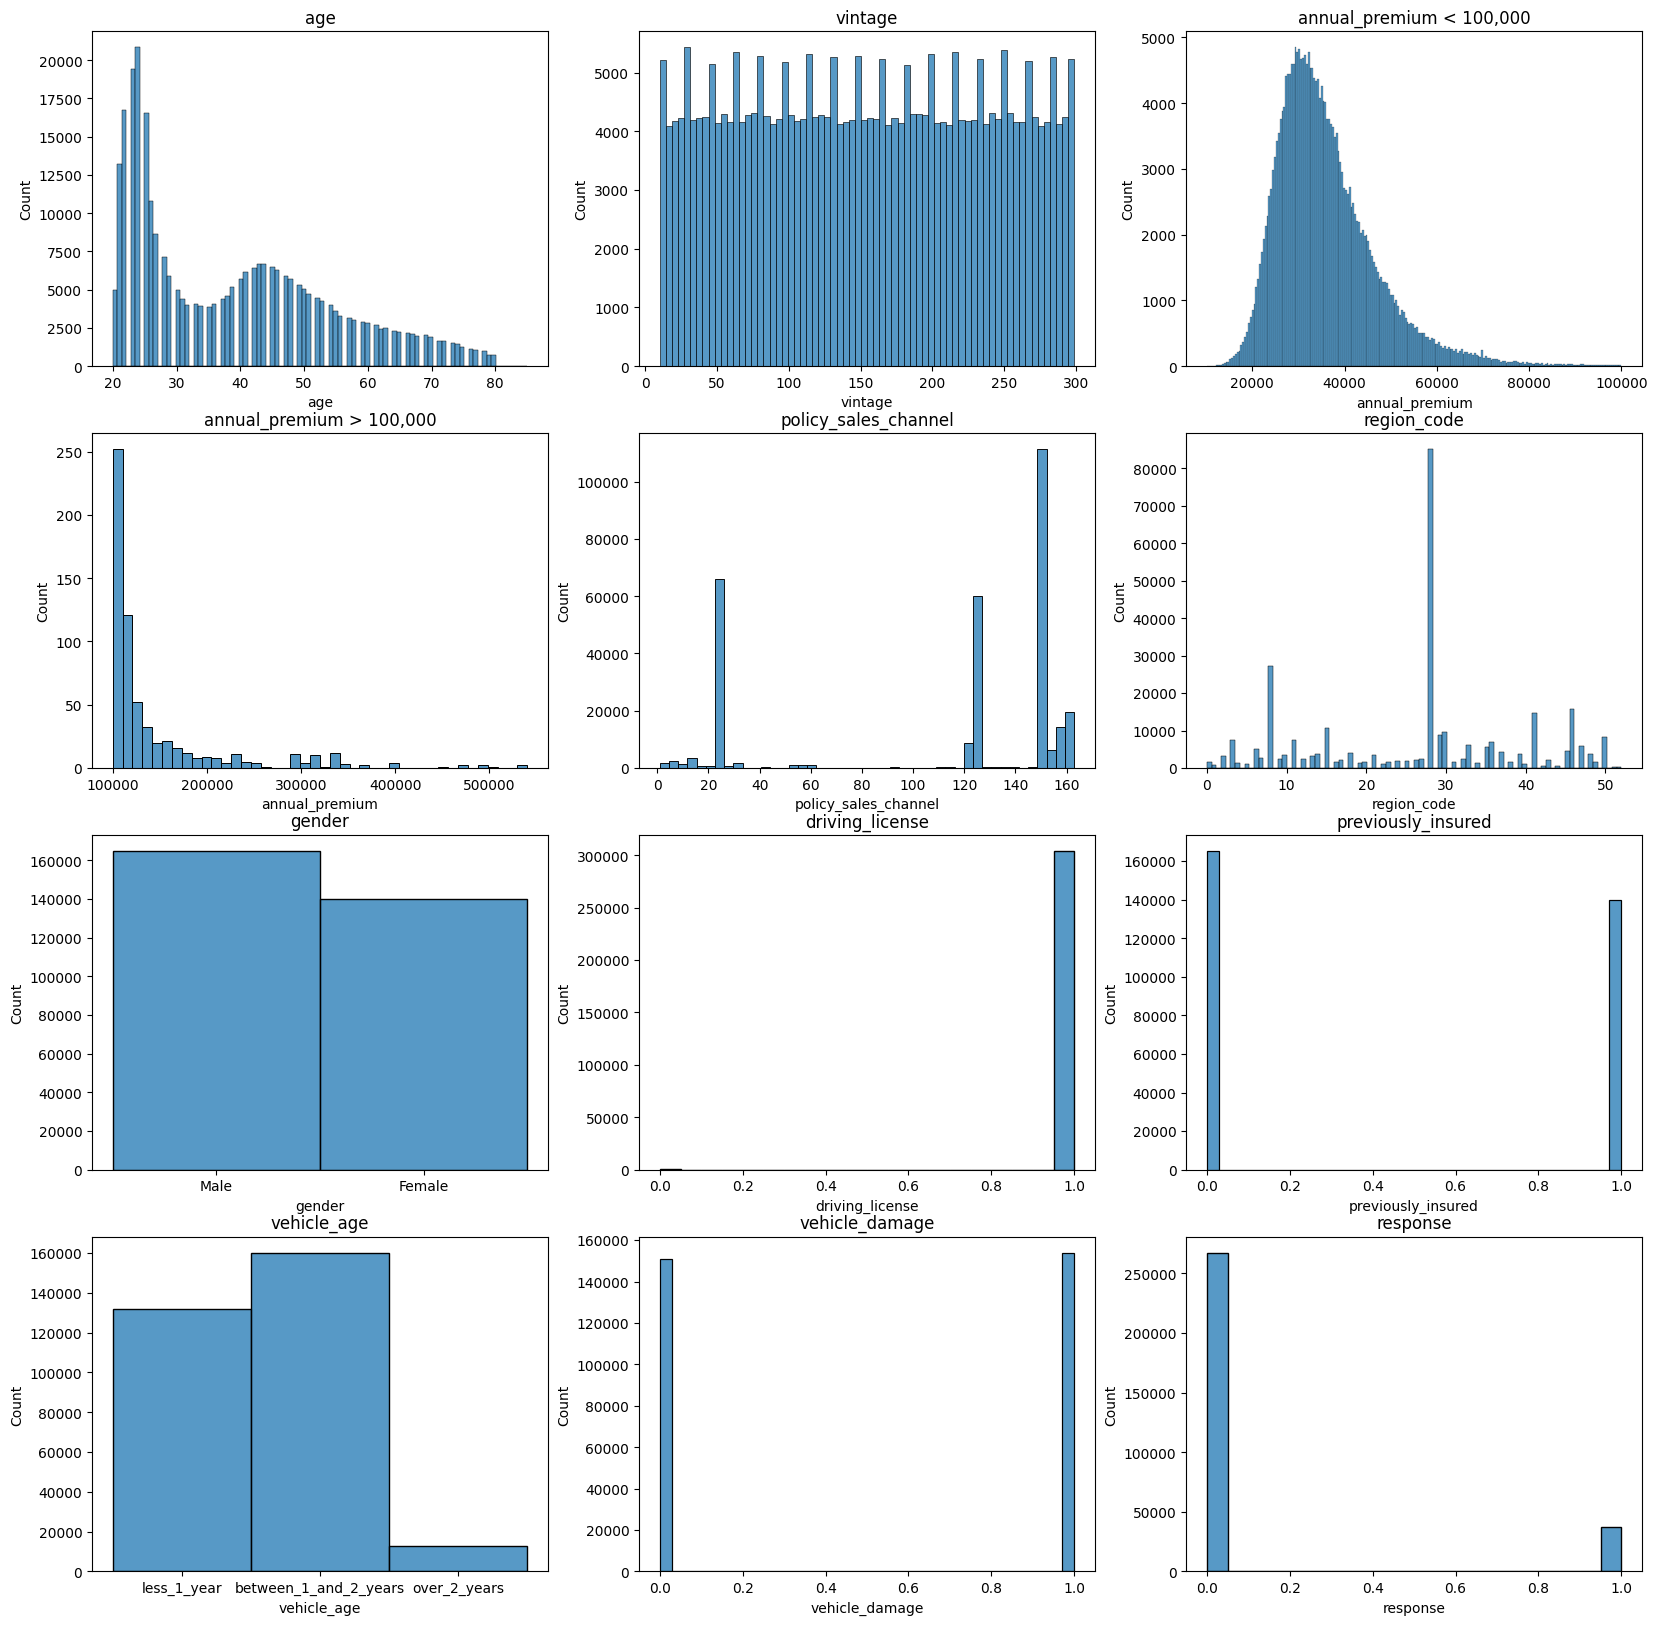

In [20]:
plt.figure(figsize = [20, 20])

plt.subplot( 4, 3, 1 )
sns.histplot( df4['age']);
plt.title('age')

plt.subplot( 4, 3, 2 )
sns.histplot( df4['vintage']);
plt.title('vintage')

plt.subplot( 4, 3, 3 )
sns.histplot( df4[(df4['annual_premium']<100000) & (df4['annual_premium']>10000)]['annual_premium']);
plt.title('annual_premium < 100,000')

plt.subplot( 4, 3, 4 )
sns.histplot( df4[df4['annual_premium']>100000]['annual_premium']);
plt.title('annual_premium > 100,000')                                      

plt.subplot( 4, 3, 5 )
sns.histplot( df4['policy_sales_channel']);
plt.title('policy_sales_channel')

plt.subplot( 4, 3, 6 )
sns.histplot( df4['region_code']);
plt.title('region_code')

plt.subplot( 4, 3, 7 )
sns.histplot( df4['gender']);
plt.title('gender')

plt.subplot( 4, 3, 8 )
sns.histplot( df4['driving_license']);
plt.title('driving_license')

plt.subplot( 4, 3, 9 )
sns.histplot( df4['previously_insured']);
plt.title('previously_insured')

plt.subplot( 4, 3, 10 )
sns.histplot( df4['vehicle_age']);
plt.title('vehicle_age')

plt.subplot( 4, 3, 11 )
sns.histplot( df4['vehicle_damage']);
plt.title('vehicle_damage')

plt.subplot( 4, 3, 12 )
sns.histplot( df4['response']);
plt.title('response')



## 4.2 - Bivariate analysis

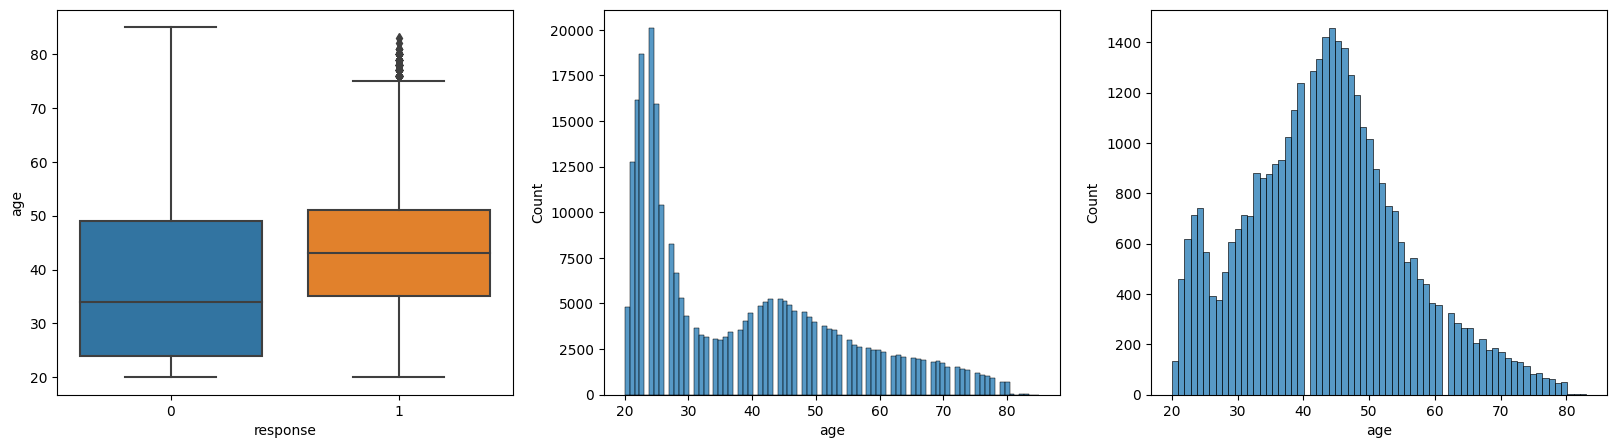

In [21]:
plt.figure(figsize = [20, 5])


plt.subplot( 1, 3, 1 )
sns.boxplot( x='response', y='age', data = df4 );

plt.subplot( 1, 3, 2 )
sns.histplot( df4.loc[df4['response']==0, 'age'] );

plt.subplot( 1, 3, 3 )
sns.histplot( df4.loc[df4['response']==1, 'age'] );


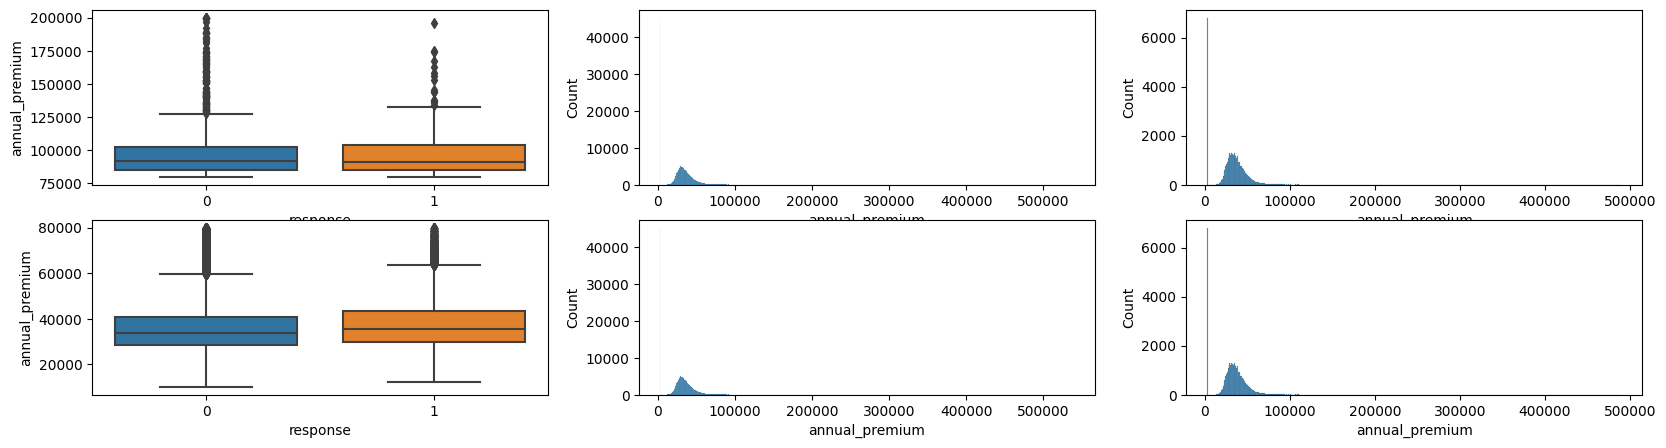

In [22]:
plt.figure(figsize = [20, 5])

aux1 = df4[ (df4['annual_premium']>80000) & (df4['annual_premium']<=200000) ]
aux2 = df4[ (df4['annual_premium']<=80000) & (df4['annual_premium']>10000) ]


plt.subplot( 2, 3, 1 )
sns.boxplot( x='response', y='annual_premium', data = aux1 );

plt.subplot( 2, 3, 2 )
sns.histplot( df4.loc[df4['response']==0, 'annual_premium'] );

plt.subplot( 2, 3, 3 )
sns.histplot( df4.loc[df4['response']==1, 'annual_premium'] );

plt.subplot( 2, 3, 4 )
sns.boxplot( x='response', y='annual_premium', data = aux2 );

plt.subplot( 2, 3, 5 )
sns.histplot( df4.loc[df4['response']==0, 'annual_premium'] );

plt.subplot( 2, 3, 6 )
sns.histplot( df4.loc[df4['response']==1, 'annual_premium'] );

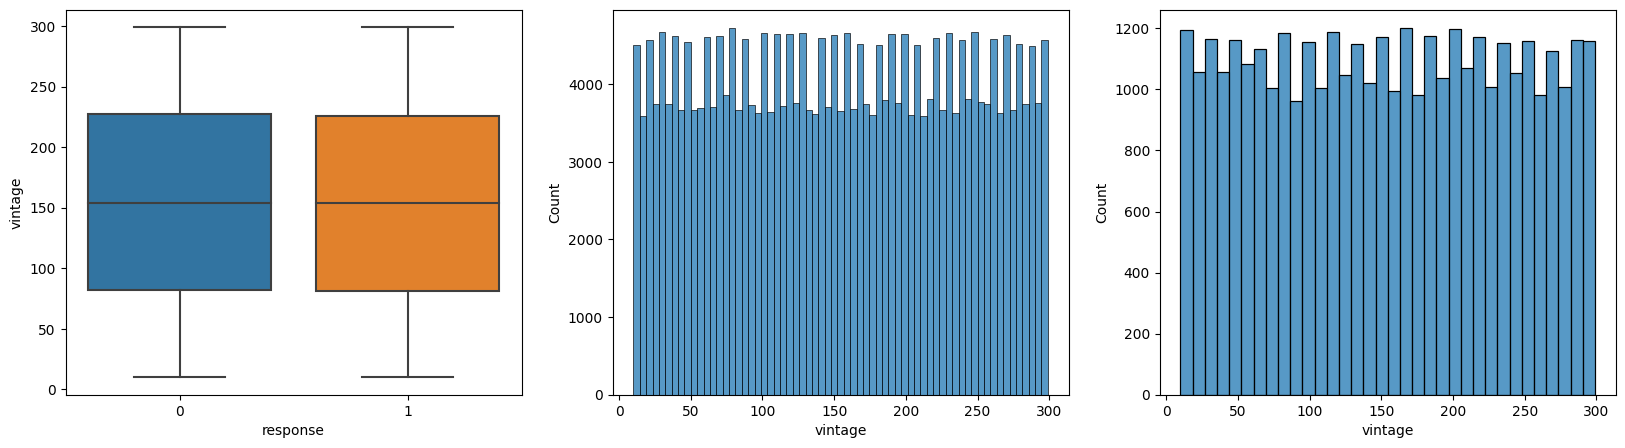

In [23]:
plt.figure(figsize = [20, 5])


plt.subplot( 1, 3, 1 )
sns.boxplot( x='response', y='vintage', data = df4 );

plt.subplot( 1, 3, 2 )
sns.histplot( df4.loc[df4['response']==0, 'vintage'] );

plt.subplot( 1, 3, 3 )
sns.histplot( df4.loc[df4['response']==1, 'vintage'] );


<Axes: xlabel='region_code', ylabel='id'>

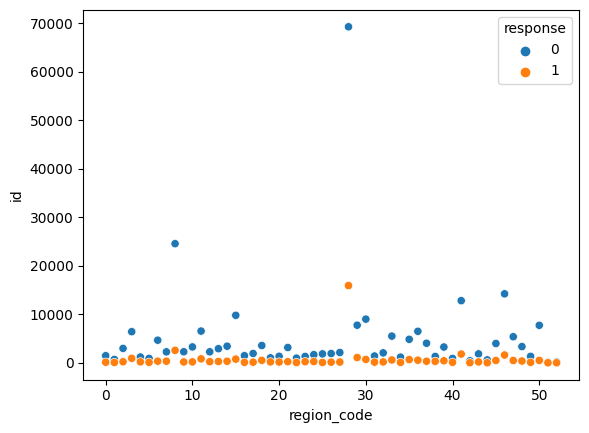

In [24]:
aux5 = df4[[ 'id', 'region_code', 'response' ]].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data = aux5 )

<BarContainer object of 150 artists>

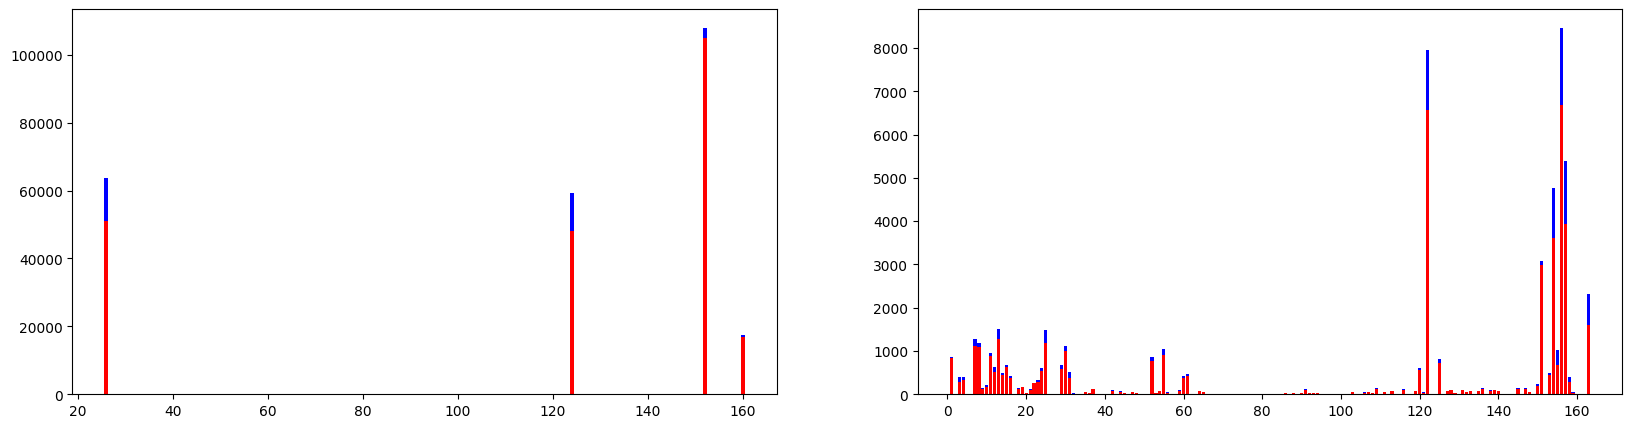

In [25]:
aux6 = df4[[ 'id', 'policy_sales_channel', 'response' ]].groupby(['policy_sales_channel', 'response']).count().reset_index()

aux7 = aux6.pivot_table(index='policy_sales_channel',columns='response', aggfunc='mean', fill_value=0).reset_index()
aux7.columns = aux7.columns.map(lambda x: f'{x[0]}_{x[1]}')

#plt.bar(aux7['policy_sales_channel_'], aux7['id_0'] , color='r')
#plt.bar(aux7['policy_sales_channel_'], aux7['id_1'] , bottom=aux7['id_0'], color='b')
#plt.show()

outliers = [26, 124, 152, 160]
aux_outliers_only = aux7[ aux7['policy_sales_channel_'].isin(outliers) ]
aux_without_outliers = aux7[ ~aux7['policy_sales_channel_'].isin(outliers) ]

plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1)
plt.bar(aux_outliers_only['policy_sales_channel_'], aux_outliers_only['id_0'] , color='r')
plt.bar(aux_outliers_only['policy_sales_channel_'], aux_outliers_only['id_1'] , bottom=aux_outliers_only['id_0'], color='b')

plt.subplot(1, 2, 2)
plt.bar(aux_without_outliers['policy_sales_channel_'], aux_without_outliers['id_0'] , color='r')
plt.bar(aux_without_outliers['policy_sales_channel_'], aux_without_outliers['id_1'] , bottom=aux_without_outliers['id_0'], color='b')

#look for how to do it in seaborn - better looking

In [26]:
pd.crosstab( df4['gender'], df4['response'], normalize='columns' )

response,0,1
gender,,
Female,0.469088,0.391164
Male,0.530912,0.608836


In [27]:
pd.crosstab( df4['driving_license'], df4['response'], normalize='columns' )


response,0,1
driving_license,,
0,0.002318,0.00091
1,0.997682,0.99909


In [28]:
pd.crosstab( df4['previously_insured'], df4['response'], normalize='columns' )

response,0,1
previously_insured,,
0,0.478321,0.996842
1,0.521679,0.003158


In [29]:
pd.crosstab( df4['vehicle_damage'], df4['response'], normalize='columns' )

response,0,1
vehicle_damage,,
0,0.561209,0.021248
1,0.438791,0.978752


In [30]:
pd.crosstab( df4['vehicle_age'], df4['response'], normalize='columns' )

response,0,1
vehicle_age,,
between_1_and_2_years,0.494828,0.744461
less_1_year,0.471230,0.154919
over_2_years,0.033942,0.100621


## 4.3 - Multivariate analysis

In [31]:
#checking types
df4['vehicle_damage'] = df4['vehicle_damage'].astype( 'object' )
df4.dtypes

id                        int64
gender                   object
age                       int64
driving_license          object
region_code              object
previously_insured       object
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel     object
vintage                   int64
response                 object
dtype: object

In [32]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df4.select_dtypes( include='object' )

## 4.3.1 - Numerical attributes

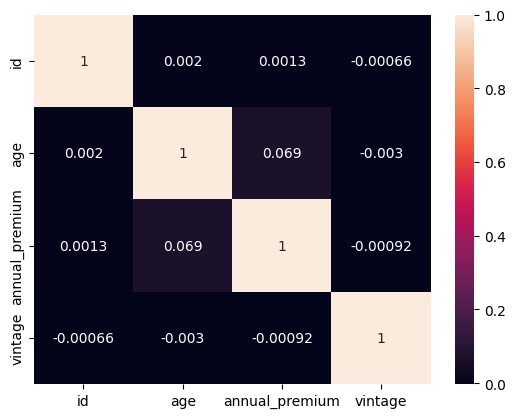

In [33]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


## 4.3.2 - Categorical attributes

In [34]:
cat_attributes.columns

Index(['gender', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'response'],
      dtype='object')

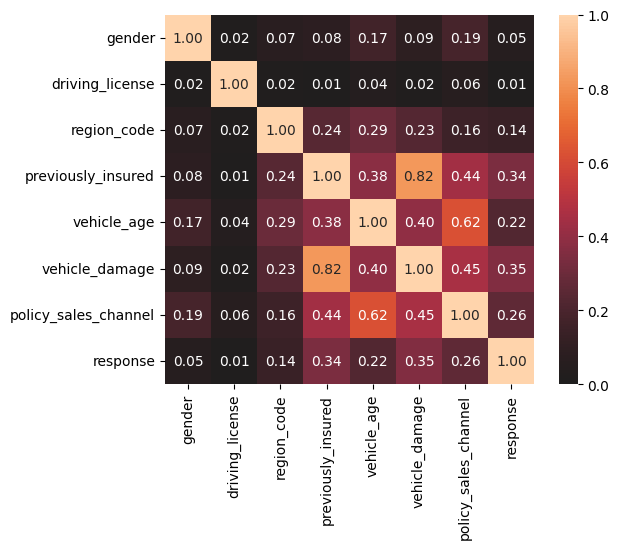

In [35]:
associations(cat_attributes, nominal_columns='auto', numerical_columns=None, 
             mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', 
             ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, 
             vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None);


# 05 - DATA PREPARATION

In [36]:
df5 = df4.copy()

## 5.1 - Standardization

In [37]:
ss = pp.StandardScaler()

#annual premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2 - Reescaling

In [38]:
#Min Max Scaler (w/o outliers)
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

#vintage
df5['vintage'] = mms_age.fit_transform( df5[['vintage']].values )


## 5.3 - Encoding

In [39]:
#One Hot Encoding
#gender
df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'] )

#Ordinal Encoding
#vehicle_age
oe = pp.OrdinalEncoder()
df5['vehicle_age'] = oe.fit_transform( df5[['vehicle_age']].values )

#Frequency Encoding
#region_code
fe_region_code = df5.groupby('region_code').size() / len(df5)
df5.loc[ :, 'region_code' ] = df5['region_code'].map(fe_region_code)

#policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[ :, 'policy_sales_channel' ] = df5['policy_sales_channel'].map(fe_policy_sales_channel)


In [40]:
df5['driving_license'] = df5['driving_license'].astype('int64')
df5['previously_insured'] = df5['previously_insured'].astype('int64')
df5['vehicle_damage'] = df5['vehicle_damage'].astype('int64')
df5['response'] = df5['response'].astype('int64')
df5['gender_Female'] = df5['gender_Female'].astype('int64')
df5['gender_Male'] = df5['gender_Male'].astype('int64')

## 5.4 - Validation preparation

In [41]:
df_val = pd.concat( [x_val, y_val], axis=1 )

In [42]:
df_val.columns = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

#vehicle age
df_val['vehicle_age'] = df_val['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                         'between_1_and_2_years' if x == '1-2 Year' else 'less_1_year' )
#vehicle damage
df_val['vehicle_damage'] = df_val['vehicle_damage'].apply( lambda x: 0 if x == 'No' else 1 )


In [43]:
#annual premium
df_val['annual_premium'] = ss.fit_transform( df_val[['annual_premium']].values )

#age
df_val['age'] = mms_age.fit_transform( df_val[['age']].values )

#vintage
df_val['vintage'] = mms_age.fit_transform( df_val[['vintage']].values )

#gender
df_val = pd.get_dummies( df_val, prefix='gender', columns=['gender'] )

#vehicle_age
oe = pp.OrdinalEncoder()
df_val['vehicle_age'] = oe.fit_transform( df_val[['vehicle_age']].values )

#region_code
fe_region_code = df_val.groupby('region_code').size() / len(df_val)
df_val.loc[ :, 'region_code' ] = df_val['region_code'].map(fe_region_code)

#policy_sales_channel
fe_policy_sales_channel = df_val.groupby('policy_sales_channel').size() / len(df_val)
df_val.loc[ :, 'policy_sales_channel' ] = df_val['policy_sales_channel'].map(fe_policy_sales_channel)


# 06 - FEATURE SELECTION

In [44]:
df6 = df5.copy()

## 6.1 - Feature importance

In [45]:
#model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

#data preparation
x_train_fs = df6.drop( ['id', 'response'], axis=1 )
y_train_fs = y_train.copy().astype('int')

forest.fit( x_train_fs, y_train_fs )


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking: 
                feature  importance
0               vintage    0.278612
0        annual_premium    0.248297
0                   age    0.167659
0           region_code    0.098582
0        vehicle_damage    0.075546
0  policy_sales_channel    0.063876
0    previously_insured    0.052363
0           vehicle_age    0.012650
0         gender_Female    0.000992
0           gender_Male    0.000938
0       driving_license    0.000485


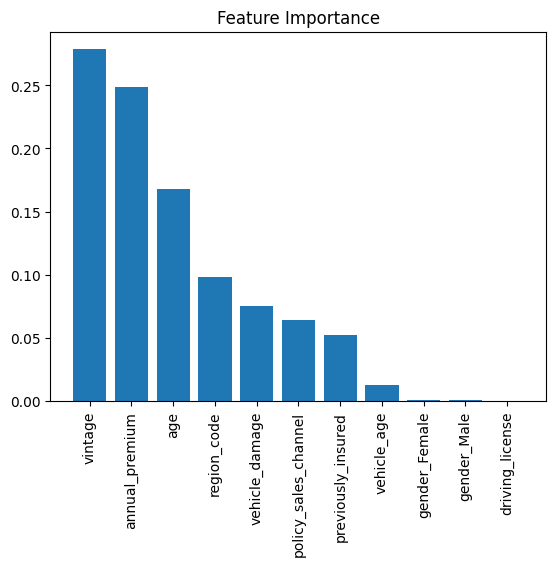

In [46]:
importances = forest.feature_importances_
#ordenate by importance - columns numbers
indices = np.argsort( importances )[::-1]

#print feature ranking
print('Feature Ranking: ')
df = pd.DataFrame()

for i, j in zip( x_train_fs, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux] , axis=0)
print(df.sort_values('importance', ascending=False))
    
#plot feature importance
plt.figure()
plt.title('Feature Importance')
plt.bar( range(x_train_fs.shape[1]), importances[indices] );
plt.xticks( range(x_train_fs.shape[1]), x_train_fs.columns[indices], rotation=90 );
#plt.xlim( -1, x_train_fs.shape[1] )
    

# 07 - MACHINE LEARNING MODELLING

In [47]:
df7 = df6.copy()

In [48]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                 'policy_sales_channel', 'previously_insured']

In [49]:
#prepare train and validation
x_train = df7[cols_selected]
y_train = pd.DataFrame(df7['response'])

x_val_ = df_val[cols_selected]
y_val_ = pd.DataFrame(df_val['response'])

df_val_ = pd.concat( [x_val_, y_val_], axis=1 )
df_train = pd.merge( x_train, y_train, left_index=True, right_index=True )

df_total = pd.concat( [df_train, df_val_] )

#df_train.to_csv( '/home/ana/repos/04-health-insurance-project/data/processed/dataset_training.csv' )
#df_val_.to_csv( '/home/ana/repos/04-health-insurance-project/data/processed/dataset_validation.csv' )


In [50]:
df_train = pd.read_csv( '/home/ana/repos/04-health-insurance-project/data/processed/dataset_training.csv', index_col=[0] )
df_val_ = pd.read_csv( '/home/ana/repos/04-health-insurance-project/data/processed/dataset_validation.csv', index_col=[0] )
df_total = pd.concat( [df_train, df_val_] )


In [51]:
x_train = df_train.iloc[:,0:-1]
y_train = pd.DataFrame(df_train['response'])

x_val_ = df_val_.iloc[:,0:-1]
y_val_ = pd.DataFrame(df_val_['response'])


## 7.1 - KNN Model

In [66]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=5)

#model training
knn_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_knn_proba = knn_model.predict_proba( x_val_ )
yhat_knn = knn_model.predict( x_val_ )

In [67]:
precision_recall_at_k( y_val_['response'].values, yhat_knn_proba, k=30000, model_name='KNN' )

Model: KNN 
Ranking Position: 30000 
Precision: 0.24993 
Recall: 0.80261


{'precision_at_k': 0.24993, 'recall_at_k': 0.80261}

In [68]:
cv_knn = kfold_cv( df_total, knn_model, model_name='KNN', topk=30000 )
cv_knn


Fold 0:
Model: KNN 
Ranking Position: 30000 
Precision: 0.25133 
Recall: 0.79983


{'precision_at_k': 0.25133, 'recall_at_k': 0.79983}


Fold 1:
Model: KNN 
Ranking Position: 30000 
Precision: 0.2448 
Recall: 0.79506


{'precision_at_k': 0.2448, 'recall_at_k': 0.79506}


Fold 2:
Model: KNN 
Ranking Position: 30000 
Precision: 0.2495 
Recall: 0.79763


{'precision_at_k': 0.2495, 'recall_at_k': 0.79763}


Fold 3:
Model: KNN 
Ranking Position: 30000 
Precision: 0.2495 
Recall: 0.79299


{'precision_at_k': 0.2495, 'recall_at_k': 0.79299}


Fold 4:
Model: KNN 
Ranking Position: 30000 
Precision: 0.2442 
Recall: 0.79432


{'precision_at_k': 0.2442, 'recall_at_k': 0.79432}

,Model Name,Precision Average,Recall Average
0,KNN,0.24787,0.79597


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

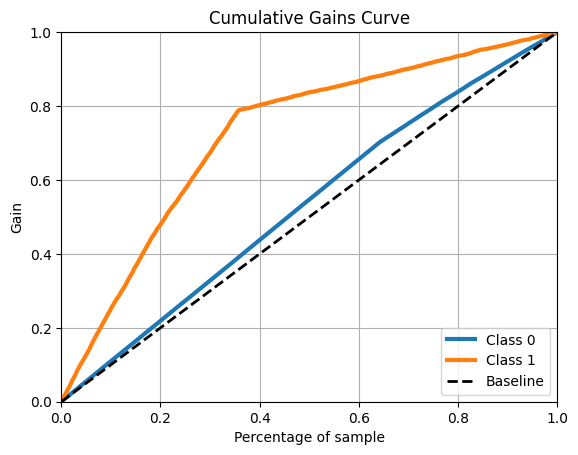

In [69]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_knn_proba )


## 7.2 - Logistic Regression

In [71]:
#model definition
lr_model = lr.LogisticRegression(random_state=16)

#model training
lr_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_lr_proba = lr_model.predict_proba( x_val_ )
yhat_lr = lr_model.predict( x_val_ )


In [72]:
precision_recall_at_k( y_val_, yhat_lr_proba, k=30000, model_name='Logistic Regression' )

Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.27173 
Recall: 0.87262


{'precision_at_k': 0.27173, 'recall_at_k': 0.87262}

In [73]:
cv_lr = kfold_cv( df_total, lr_model, topk=30000, model_name='Logistic Regression' )
cv_lr


Fold 0:
Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.27423 
Recall: 0.87271


{'precision_at_k': 0.27423, 'recall_at_k': 0.87271}


Fold 1:
Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.26883 
Recall: 0.87312


{'precision_at_k': 0.26883, 'recall_at_k': 0.87312}


Fold 2:
Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.27277 
Recall: 0.87202


{'precision_at_k': 0.27277, 'recall_at_k': 0.87202}


Fold 3:
Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.27533 
Recall: 0.87509


{'precision_at_k': 0.27533, 'recall_at_k': 0.87509}


Fold 4:
Model: Logistic Regression 
Ranking Position: 30000 
Precision: 0.2682 
Recall: 0.87238


{'precision_at_k': 0.2682, 'recall_at_k': 0.87238}

,Model Name,Precision Average,Recall Average
0,Logistic Regression,0.27187,0.87306


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

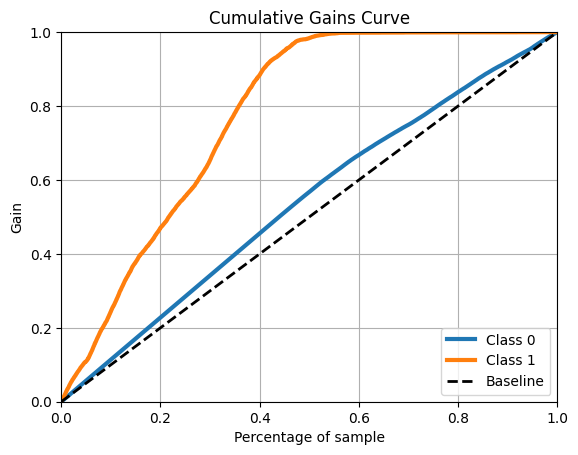

In [75]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_lr_proba )


## 7.3 - XGBoost Classifier

In [91]:
#model definition
xgb_model = xgb.XGBClassifier( objective = 'reg:squarederror', 
                       n_estimators = 2000, 
                       eta = 0.01, 
                       max_depth = 10, 
                       subsample = 0.7,
                       colsample_bytree = 0.9, 
                       min_child_weight = 3 )


#model training
xgb_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_xgb_proba = xgb_model.predict_proba( x_val_ )
yhat_xgb = xgb_model.predict( x_val_ )



In [92]:
precision_recall_at_k( y_val_, yhat_xgb_proba, k=30000, model_name='XGBoost' )

Model: XGBoost 
Ranking Position: 30000 
Precision: 0.28367 
Recall: 0.91094


{'precision_at_k': 0.28367, 'recall_at_k': 0.91094}

In [93]:
cv_xgb = kfold_cv( df_total, xgb_model, model_name='XGBoost', topk=30000 )
cv_xgb


Fold 0:
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2862 
Recall: 0.91079


{'precision_at_k': 0.2862, 'recall_at_k': 0.91079}


Fold 1:
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.28133 
Recall: 0.91372


{'precision_at_k': 0.28133, 'recall_at_k': 0.91372}


Fold 2:
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2856 
Recall: 0.91304


{'precision_at_k': 0.2856, 'recall_at_k': 0.91304}


Fold 3:
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2874 
Recall: 0.91344


{'precision_at_k': 0.2874, 'recall_at_k': 0.91344}


Fold 4:
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.28097 
Recall: 0.91391


{'precision_at_k': 0.28097, 'recall_at_k': 0.91391}

,Model Name,Precision Average,Recall Average
0,XGBoost,0.2843,0.91298


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

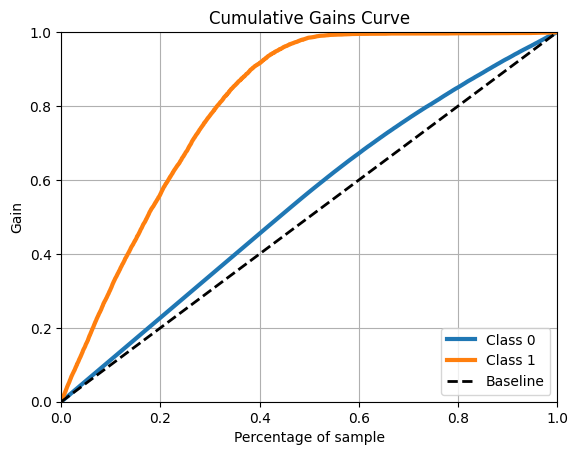

In [94]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_xgb_proba )


## 7.4 - Random Forest Classifier

In [76]:
#model definition
rf_model = en.RandomForestClassifier( n_estimators = 100, n_jobs = -1, random_state = 42 )


#model training
rf_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_rf_proba = rf_model.predict_proba( x_val_ )
yhat_rf = rf_model.predict( x_val_ )



In [79]:
precision_recall_at_k( y_val_, yhat_rf_proba, k=30000, model_name='Random Forest' )

Model: Random Forest 
Ranking Position: 30000 
Precision: 0.27387 
Recall: 0.87947


{'precision_at_k': 0.27387, 'recall_at_k': 0.87947}

In [80]:
cv_rf = kfold_cv( df_total, rf_model, topk=30000, model_name='Random Forest' )
cv_rf


Fold 0:
Model: Random Forest 
Ranking Position: 30000 
Precision: 0.27663 
Recall: 0.88034


{'precision_at_k': 0.27663, 'recall_at_k': 0.88034}


Fold 1:
Model: Random Forest 
Ranking Position: 30000 
Precision: 0.27293 
Recall: 0.88643


{'precision_at_k': 0.27293, 'recall_at_k': 0.88643}


Fold 2:
Model: Random Forest 
Ranking Position: 30000 
Precision: 0.27723 
Recall: 0.8863


{'precision_at_k': 0.27723, 'recall_at_k': 0.8863}


Fold 3:
Model: Random Forest 
Ranking Position: 30000 
Precision: 0.2777 
Recall: 0.88261


{'precision_at_k': 0.2777, 'recall_at_k': 0.88261}


Fold 4:
Model: Random Forest 
Ranking Position: 30000 
Precision: 0.27253 
Recall: 0.88648


{'precision_at_k': 0.27253, 'recall_at_k': 0.88648}

,Model Name,Precision Average,Recall Average
0,Random Forest,0.2754,0.88443


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

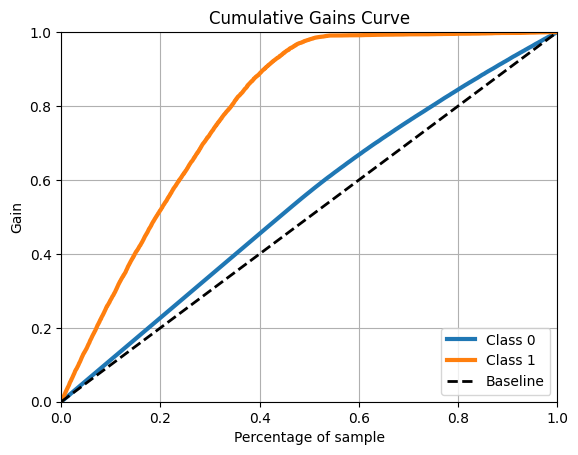

In [81]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_rf_proba )


## 7.5 - CatBoost Classifier

In [82]:
#model definition
ctb_model = ctb.CatBoostClassifier( iterations=5, learning_rate=0.1 )


#model training
ctb_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_ctb_proba = ctb_model.predict_proba( x_val_ )
yhat_ctb = ctb_model.predict( x_val_ )


0:	learn: 0.6320781	total: 99.1ms	remaining: 396ms
1:	learn: 0.5823198	total: 136ms	remaining: 204ms
2:	learn: 0.5407080	total: 174ms	remaining: 116ms
3:	learn: 0.5061510	total: 208ms	remaining: 52.1ms
4:	learn: 0.4766733	total: 248ms	remaining: 0us


In [83]:
precision_recall_at_k( y_val_, yhat_ctb_proba, k=30000, model_name='CatBoost' )

Model: CatBoost 
Ranking Position: 30000 
Precision: 0.2807 
Recall: 0.90141


{'precision_at_k': 0.2807, 'recall_at_k': 0.90141}

In [84]:
cv_ctb = kfold_cv( df_total, ctb_model, topk=30000, model_name='CatBoost' )
cv_ctb


Fold 0:
0:	learn: 0.6319464	total: 34ms	remaining: 136ms
1:	learn: 0.5821073	total: 63.5ms	remaining: 95.2ms
2:	learn: 0.5405273	total: 93.4ms	remaining: 62.2ms
3:	learn: 0.5058768	total: 119ms	remaining: 29.7ms
4:	learn: 0.4764105	total: 150ms	remaining: 0us
Model: CatBoost 
Ranking Position: 30000 
Precision: 0.28357 
Recall: 0.90241


{'precision_at_k': 0.28357, 'recall_at_k': 0.90241}


Fold 1:
0:	learn: 0.6320410	total: 32.9ms	remaining: 132ms
1:	learn: 0.5822763	total: 60.7ms	remaining: 91.1ms
2:	learn: 0.5407908	total: 90.5ms	remaining: 60.3ms
3:	learn: 0.5061922	total: 116ms	remaining: 29.1ms
4:	learn: 0.4767740	total: 148ms	remaining: 0us
Model: CatBoost 
Ranking Position: 30000 
Precision: 0.27597 
Recall: 0.89629


{'precision_at_k': 0.27597, 'recall_at_k': 0.89629}


Fold 2:
0:	learn: 0.6319506	total: 35.7ms	remaining: 143ms
1:	learn: 0.5821454	total: 66.9ms	remaining: 100ms
2:	learn: 0.5405819	total: 99.9ms	remaining: 66.6ms
3:	learn: 0.5059265	total: 130ms	remaining: 32.4ms
4:	learn: 0.4764722	total: 164ms	remaining: 0us
Model: CatBoost 
Ranking Position: 30000 
Precision: 0.2817 
Recall: 0.90058


{'precision_at_k': 0.2817, 'recall_at_k': 0.90058}


Fold 3:
0:	learn: 0.6319339	total: 37.2ms	remaining: 149ms
1:	learn: 0.5820682	total: 70.1ms	remaining: 105ms
2:	learn: 0.5404973	total: 104ms	remaining: 69.6ms
3:	learn: 0.5058433	total: 132ms	remaining: 33ms
4:	learn: 0.4763780	total: 167ms	remaining: 0us
Model: CatBoost 
Ranking Position: 30000 
Precision: 0.28357 
Recall: 0.90126


{'precision_at_k': 0.28357, 'recall_at_k': 0.90126}


Fold 4:
0:	learn: 0.6320563	total: 44.9ms	remaining: 180ms
1:	learn: 0.5823067	total: 88.8ms	remaining: 133ms
2:	learn: 0.5407894	total: 135ms	remaining: 89.9ms
3:	learn: 0.5062280	total: 172ms	remaining: 43ms
4:	learn: 0.4768002	total: 206ms	remaining: 0us
Model: CatBoost 
Ranking Position: 30000 
Precision: 0.2779 
Recall: 0.90394


{'precision_at_k': 0.2779, 'recall_at_k': 0.90394}

,Model Name,Precision Average,Recall Average
0,CatBoost,0.28054,0.9009


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

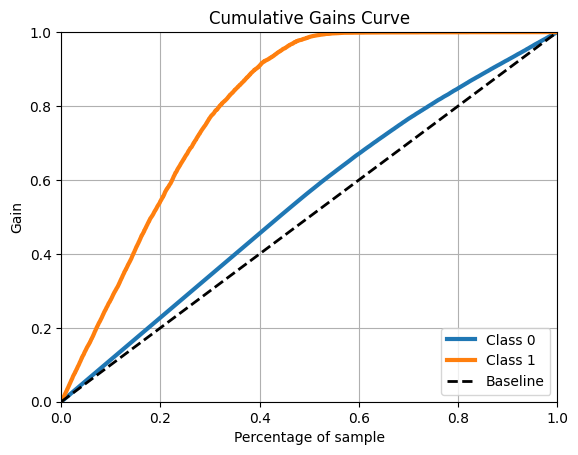

In [85]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_ctb_proba )


## 7.6 - LGBM Classifier

In [56]:
#model definition
lgbm_model = lgb.LGBMClassifier( learning_rate=0.1, num_leaves= 20, max_depth=60, scale_pos_weight=4 )


#model training
lgbm_model.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_lgbm_proba = lgbm_model.predict_proba( x_val_ )
yhat_lgbm = lgbm_model.predict( x_val_ )


In [57]:
precision_recall_at_k( y_val_, yhat_lgbm_proba, k=30000, model_name='LGBM' )

Model: LGBM 
Ranking Position: 30000 
Precision: 0.28463 
Recall: 0.91404


{'precision_at_k': 0.28463, 'recall_at_k': 0.91404}

In [88]:
cv_lgbm = kfold_cv( df_total,lgbm_model, topk=30000, model_name='LGBM' )
cv_lgbm


Fold 0:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.28777 
Recall: 0.91577


{'precision_at_k': 0.28777, 'recall_at_k': 0.91577}


Fold 1:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.28227 
Recall: 0.91675


{'precision_at_k': 0.28227, 'recall_at_k': 0.91675}


Fold 2:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.2859 
Recall: 0.914


{'precision_at_k': 0.2859, 'recall_at_k': 0.914}


Fold 3:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.28823 
Recall: 0.91609


{'precision_at_k': 0.28823, 'recall_at_k': 0.91609}


Fold 4:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.2819 
Recall: 0.91695


{'precision_at_k': 0.2819, 'recall_at_k': 0.91695}

,Model Name,Precision Average,Recall Average
0,LGBM,0.28521,0.91591


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

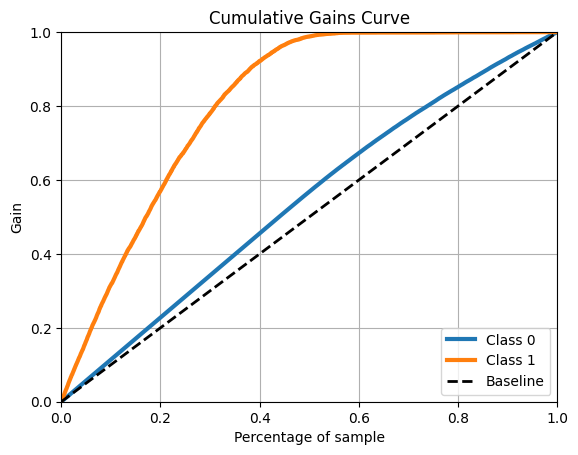

In [90]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_lgbm_proba )


# 08 - HYPERPARAMETER FINE TUNNING

In [288]:
#logistic regressor was chosen for fine tuning

In [300]:
param = {
         'scale_pos_weight':[3, 5, 7], 
         'num_leaves':[30, 40, 50],
         'max_deaph':[30, 40, 50], 
         'subsample': [0.4, 1],
         'colsample_bytree': [0.4, 1]
         }

MAX_EVALS = 5

In [314]:
y_val_.dtypes

response    int64
dtype: object

In [321]:
#table to store each iteration result
final_resultx = []
for i in range( MAX_EVALS ):
    
    print( '\nIteração nº: {} '.format(i+1) )
    
    #chose values for parameters randomly
    hp = {k: random.choice( v ) for k, v in param.items()}
    print(hp)
    
    # model
    # hp is a dictionary containing all possible values for each parameter
    #model definition
    lgbm_model = lgb.LGBMClassifier( learning_rate=0.1,
                                     scale_pos_weight= hp['scale_pos_weight'], 
                                     num_leaves= hp['num_leaves'],
                                     max_depth= hp['max_deaph'],
                                     subsample= hp['subsample'],
                                     colsample_bytree= hp['colsample_bytree']
                                    )


    #model training
    lgbm_model.fit( x_train, y_train )

    #model prediction over data it never saw - generalization
    yhat_lgbm_proba = lgbm_model.predict_proba( x_val_ )
    
    # performance
    resultx = precision_recall_at_k( y_val_, yhat_lgbm_proba, k=30000, model_name='XGBoost' )
    
    #result
    final_resultx.append( resultx['recall_at_k'] )
    
final_resultx


Iteração nº: 1 
{'scale_pos_weight': 3, 'num_leaves': 50, 'max_deaph': 30, 'subsample': 1, 'colsample_bytree': 0.4}
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2858 
Recall: 0.91779

Iteração nº: 2 
{'scale_pos_weight': 3, 'num_leaves': 30, 'max_deaph': 30, 'subsample': 0.4, 'colsample_bytree': 0.4}
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.28567 
Recall: 0.91736

Iteração nº: 3 
{'scale_pos_weight': 3, 'num_leaves': 40, 'max_deaph': 50, 'subsample': 1, 'colsample_bytree': 1}
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2847 
Recall: 0.91426

Iteração nº: 4 
{'scale_pos_weight': 5, 'num_leaves': 30, 'max_deaph': 30, 'subsample': 1, 'colsample_bytree': 0.4}
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.28573 
Recall: 0.91758

Iteração nº: 5 
{'scale_pos_weight': 3, 'num_leaves': 50, 'max_deaph': 50, 'subsample': 1, 'colsample_bytree': 0.4}
Model: XGBoost 
Ranking Position: 30000 
Precision: 0.2858 
Recall: 0.91779


[0.91779, 0.91736, 0.91426, 0.91758, 0.91779]

In [52]:
param_tuned = { 'objective': 'binary',
                'learning_rate':0.1,
                'scale_pos_weight': 3, 
                'num_leaves': 50, 
                'max_deaph': 30, 
                'subsample': 1, 
                'colsample_bytree': 0.4
            }


# 09 - ERROR AND PERFORMANCE

## 9.1 - Training performance

In [53]:
lgbm_model_final = lgb.LGBMClassifier( 
                                     objective= param_tuned['objective'],
                                     learning_rate=0.1,
                                     scale_pos_weight= param_tuned['scale_pos_weight'], 
                                     num_leaves= param_tuned['num_leaves'],
                                     max_depth= param_tuned['max_deaph'],
                                     subsample= param_tuned['subsample'],
                                     colsample_bytree= param_tuned['colsample_bytree']
                                    )
                                    
#model training
lgbm_model_final.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_final_proba = lgbm_model_final.predict_proba( x_val_ )
yhat_final = lgbm_model_final.predict( x_val_ )
    

In [54]:
precision_recall_at_k( y_val_, yhat_final_proba, k=30000, model_name='LGBM Final' )

Model: LGBM Final 
Ranking Position: 30000 
Precision: 0.2858 
Recall: 0.91779


{'precision_at_k': 0.2858, 'recall_at_k': 0.91779}

In [58]:
cv_lgbm_final = kfold_cv( df_total,lgbm_model, topk=30000, model_name='LGBM' )
cv_lgbm_final


Fold 0:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.2881 
Recall: 0.91683


{'precision_at_k': 0.2881, 'recall_at_k': 0.91683}


Fold 1:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.28247 
Recall: 0.9174


{'precision_at_k': 0.28247, 'recall_at_k': 0.9174}


Fold 2:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.2863 
Recall: 0.91528


{'precision_at_k': 0.2863, 'recall_at_k': 0.91528}


Fold 3:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.2884 
Recall: 0.91662


{'precision_at_k': 0.2884, 'recall_at_k': 0.91662}


Fold 4:
Model: LGBM 
Ranking Position: 30000 
Precision: 0.28127 
Recall: 0.91489


{'precision_at_k': 0.28127, 'recall_at_k': 0.91489}

,Model Name,Precision Average,Recall Average
0,LGBM,0.28531,0.9162


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

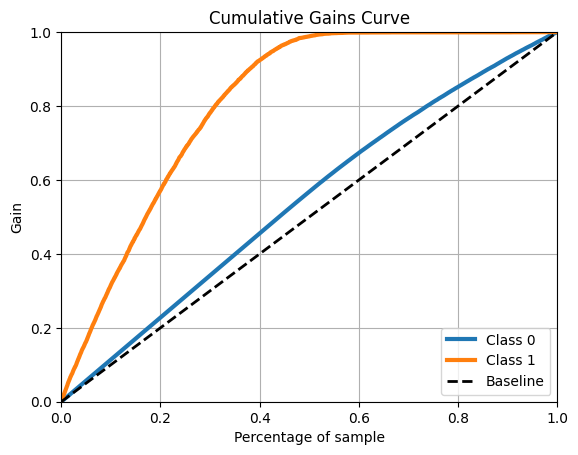

In [59]:
#cumulative gain graph
skplt.metrics.plot_cumulative_gain( y_val_, yhat_final_proba )

## 9.2 - Best k

In [60]:
#Considering the cost of a call is $1.00 and the revenue of cross-sell is $500.00 per client.
#Considering the calls are the only costs involved.
#How many calls should I suggest?

In [61]:
#y_final = pd.concat( [y_val_, pd.DataFrame(yhat_final_proba, index=y_val_.index) ], axis=1, join='inner' )
#y_final.columns = ['y_true', 'y_proba', 'remove']
y_final = pd.DataFrame()
y_final['y_true'] = y_val_
y_final['y_proba'] = yhat_final_proba[:,1].tolist()
y_final = y_final.sort_values( 'y_proba', ascending=False )
y_final['k'] = [ i for i in range(len(y_final)) ]
 
#criar coluna com a receita acumulada baseado em y_val
premium = 500
y_final['revenue'] = y_final['y_true'].multiply( premium )
y_final['revenue_at_k'] = y_final['revenue'].cumsum()

#criar coluna com o custo acumulado, cada linha é mais um custo até eu atigir 100% dos clientes interessados
cost_per_call = 10
y_final['cost_at_k'] = y_final['k'].multiply( cost_per_call )

#criar coluna com o lucro: receita - custo
y_final['profit'] = y_final['revenue_at_k'] - y_final['cost_at_k']

#plotar gráfico e encontrar k aonde o lucro é máximo


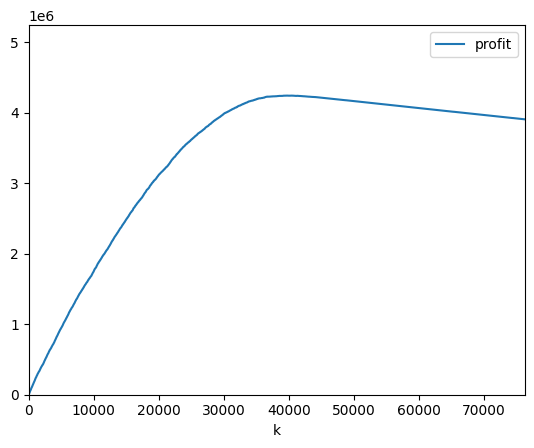

In [62]:
y_final.plot(x='k', y='profit')
plt.xlabel = ('k')
plt.ylabel = ('profit')

plt.xlim([0, y_final['k'].max()])
plt.ylim([0, y_final['profit'].max()+1e6])

plt.show()

In [63]:
y_final[y_final['profit']==y_final['profit'].max()]

,y_true,y_proba,k,revenue,revenue_at_k,cost_at_k,profit
169698,1,0.048426,40254,500,4648000,402540,4245460


## 9.3 - Final list

In [64]:
df_test.columns = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage']

#vehicle age
df_test['vehicle_age'] = df_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                         'between_1_and_2_years' if x == '1-2 Year' else 'less_1_year' )
#vehicle damage
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 0 if x == 'No' else 1 )


In [65]:
#annual premium
df_test['annual_premium'] = ss.fit_transform( df_test[['annual_premium']].values )

#age
df_test['age'] = mms_age.fit_transform( df_test[['age']].values )

#vintage
df_test['vintage'] = mms_age.fit_transform( df_test[['vintage']].values )

#gender
df_test = pd.get_dummies( df_test, prefix='gender', columns=['gender'] )

#vehicle_age
oe = pp.OrdinalEncoder()
df_test['vehicle_age'] = oe.fit_transform( df_test[['vehicle_age']].values )

#region_code
fe_region_code = df_test.groupby('region_code').size() / len(df_test)
df_test.loc[ :, 'region_code' ] = df_test['region_code'].map(fe_region_code)

#policy_sales_channel
fe_policy_sales_channel = df_test.groupby('policy_sales_channel').size() / len(df_test)
df_test.loc[ :, 'policy_sales_channel' ] = df_test['policy_sales_channel'].map(fe_policy_sales_channel)


In [66]:
df_test = df_test[cols_selected]
x_test = df_test.copy()


In [67]:
lgbm_model_final = lgb.LGBMClassifier( 
                                     objective= param_tuned['objective'],
                                     learning_rate=0.1,
                                     scale_pos_weight= param_tuned['scale_pos_weight'], 
                                     num_leaves= param_tuned['num_leaves'],
                                     max_depth= param_tuned['max_deaph'],
                                     subsample= param_tuned['subsample'],
                                     colsample_bytree= param_tuned['colsample_bytree']
                                    )
                                    
#model training
lgbm_model_final.fit( x_train, y_train )

#model prediction over data it never saw - generalization
yhat_final_proba = lgbm_model_final.predict_proba( x_test )
yhat_final = lgbm_model_final.predict( x_test )


In [82]:
df_submission = pd.read_csv( '../data/raw/sample_submission.csv' )

df_submission['Response'] = yhat_final.tolist()

#df_submission.to_csv( '../data/processed//my_submission.csv' )


# 10 - DEPLOY MODEL TO PRODUCTION